In [2]:
#
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [3]:
# load data and Preprocessin
train = pd.read_csv(r'..\Data\train.csv', parse_dates=['Date'])
test = pd.read_csv(r'..\Data\test.csv', parse_dates=['Date'])
store = pd.read_csv(r'..\Data\store.csv')

C:\Users\eep\AppData\Local\Temp\ipykernel_31660\2920406418.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(r'..\Data\train.csv', parse_dates=['Date'])


In [4]:
# Convert 'Date' columns to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Fill missing values in 'StateHoliday' with '0' (assuming no holiday)
train['StateHoliday'] = train['StateHoliday'].fillna('0')
test['StateHoliday'] = test['StateHoliday'].fillna('0')

# Ensure all values in 'StateHoliday' are strings before mapping
train['StateHoliday'] = train['StateHoliday'].astype(str)
test['StateHoliday'] = test['StateHoliday'].astype(str)

# Map 'StateHoliday' values to numeric (0 for '0', 1 for 'a', 2 for 'b', etc.)
train['StateHoliday'] = train['StateHoliday'].map({'0': 0, 'a': 1, 'b': 2, 'c': 3})
test['StateHoliday'] = test['StateHoliday'].map({'0': 0, 'a': 1})

# Check for NaN values after mapping and handle them by filling with 0 and converting to int
train['StateHoliday'] = train['StateHoliday'].fillna(0).astype(int)
test['StateHoliday'] = test['StateHoliday'].fillna(0).astype(int)

# Verify the conversion
print(train['StateHoliday'].head())
print(test['StateHoliday'].head())

0    0
1    0
2    0
3    0
4    0
Name: StateHoliday, dtype: int32
0    0
1    0
2    0
3    0
4    0
Name: StateHoliday, dtype: int32


In [5]:
# Check for missing values
print(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [6]:
# Extract features from 'Date'
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.isocalendar().week
train['DayOfWeek'] = train['Date'].dt.dayofweek

# Repeat for test set
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['WeekOfYear'] = test['Date'].dt.isocalendar().week
test['DayOfWeek'] = test['Date'].dt.dayofweek


In [7]:
 #Add New Features
# creating categorical features (month segments)
train['MonthSegment'] = pd.cut(train['Day'], bins=[0, 10, 20, 31], labels=['Early', 'Mid', 'Late'], right=True)
test['MonthSegment'] = pd.cut(test['Day'], bins=[0, 10, 20, 31], labels=['Early', 'Mid', 'Late'], right=True)

# Select numeric columns for scaling
numeric_features_train = ['Sales', 'Customers', 'Promo', 'StateHoliday', 'SchoolHoliday']
numeric_features_test = ['Promo', 'StateHoliday', 'SchoolHoliday']  # Exclude 'Sales' and 'Customers'

# Initialize the StandardScaler for the training dataset
scaler_train = StandardScaler()
train[numeric_features_train] = scaler_train.fit_transform(train[numeric_features_train])

# Initialize a different StandardScaler for the test dataset
scaler_test = StandardScaler()
test[numeric_features_test] = scaler_test.fit_transform(test[numeric_features_test])

# Check the final data types and the first few rows of the dataset
print(train.dtypes)
print(train.head())
print(test.dtypes)
print(train.head())

Store                     int64
DayOfWeek                 int32
Date             datetime64[ns]
Sales                   float64
Customers               float64
Open                      int64
Promo                   float64
StateHoliday            float64
SchoolHoliday           float64
Year                      int32
Month                     int32
Day                       int32
WeekOfYear               UInt32
MonthSegment           category
dtype: object
   Store  DayOfWeek       Date     Sales  ...  Month  Day  WeekOfYear  MonthSegment
0      1          4 2015-07-31 -0.132683  ...      7   31          31          Late
1      2          4 2015-07-31  0.075373  ...      7   31          31          Late
2      3          4 2015-07-31  0.659800  ...      7   31          31          Late
3      4          4 2015-07-31  2.135414  ...      7   31          31          Late
4      5          4 2015-07-31 -0.247231  ...      7   31          31          Late

[5 rows x 14 columns]
Id         

In [8]:
# Features and target variable
X = train.drop(columns=['Sales', 'Date'])  # Drop target variable and any non-numeric columns
y = train['Sales']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical features
# Corrected to only include numeric features
numeric_features = ['Customers', 'Promo'] 
categorical_features = ['MonthSegment', 'StateHoliday', 'SchoolHoliday'] 

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 0.14399346718320413
R² Score: 0.8556840467636682


In [9]:
# Create a DataFrame to show actual vs predicted values
results = pd.DataFrame({'Actual Sales': y_val, 'Predicted Sales': y_pred})
print(results.head())  # Display the first few rows of actual vs predicted sales

        Actual Sales  Predicted Sales
76435      -1.499723        -1.499723
923026     -0.058655         0.579576
731180      0.439796         0.693115
790350     -0.626978        -0.642233
252134      1.465011         0.708196


In [10]:
from sklearn.metrics import mean_absolute_error

# Evaluate
y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

# Print evaluation metrics
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.24596165060694028


In [11]:
# Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define the corrected parameter grid (removed 'auto' for max_features)
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_features': ['sqrt', 'log2'],  # 'auto' removed
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
}

# Set up GridSearchCV
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=20, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


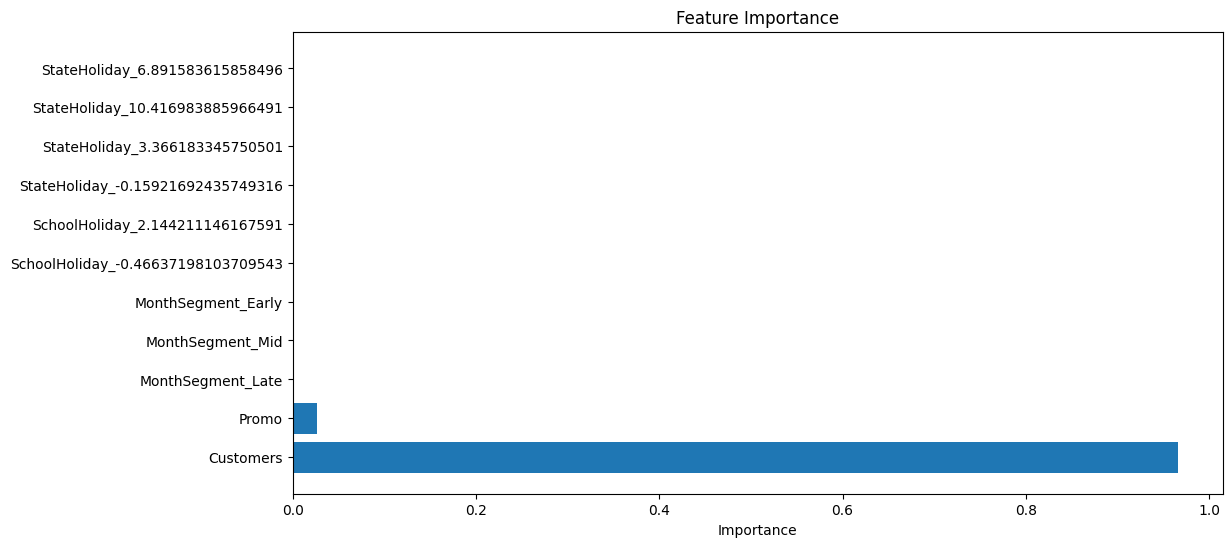

In [13]:
#visualize which features are most influential in predicting sales.Post Prediction Analysis
#Feature Importance
#explore feature importance in Random Forest model, extract the feature importances from the trained model within pipeline. 

# Access the Random Forest model from the pipeline
model = pipeline.named_steps['model']

# Get feature names after preprocessing
categorical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe = categorical_transformer

# Combine feature names
feature_names = np.concatenate([numeric_features, ohe.get_feature_names_out(categorical_features)])

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


#. Estimating Confidence Intervals for Predictions
#To estimate the confidence interval of predictions, use the concept of bootstrapping. This involves creating multiple subsets of training data, training the model on each subset, and then making predictions. By aggregating these predictions, estimate a confidence interval around predictions.
#By analyzing feature importance, understand the drivers behind sales predictions. Using bootstrapping to estimate confidence intervals provides a robust way to quantify the uncertainty of predictions, helping to make informed decisions based on the predictions and their reliability.


In [21]:
# Define a function for bootstrapping
# Function for bootstrapping predictions with batch processing
def bootstrap_predictions(model, X_train, y_train, X_val, n_iterations=100, batch_size=100):
    pred_mean = np.zeros(X_val.shape[0])
    lower_bound = np.zeros(X_val.shape[0])
    upper_bound = np.zeros(X_val.shape[0])

    for batch_start in range(0, n_iterations, batch_size):
        current_batch_size = min(batch_size, n_iterations - batch_start)
        batch_preds = np.zeros((current_batch_size, X_val.shape[0]))
        
        for i in range(current_batch_size):
            # Create a bootstrap sample
            X_bootstrap = X_train.sample(frac=1, replace=True, random_state=batch_start + i)
            y_bootstrap = y_train.loc[X_bootstrap.index]
            
            # Fit model on bootstrap sample
            model.fit(X_bootstrap, y_bootstrap)
            
            # Store predictions for current iteration
            batch_preds[i] = model.predict(X_val)
        
        # Update cumulative mean and confidence intervals
        pred_mean += batch_preds.mean(axis=0)
        lower_bound += np.percentile(batch_preds, 2.5, axis=0)
        upper_bound += np.percentile(batch_preds, 97.5, axis=0)

    # Average the means and percentiles over all batches
    pred_mean /= (n_iterations // batch_size)
    lower_bound /= (n_iterations // batch_size)
    upper_bound /= (n_iterations // batch_size)

    return pred_mean, lower_bound, upper_bound

# Generate bootstrap predictions
n_iterations = 100
batch_size = 10
pred_mean, lower_bound, upper_bound = bootstrap_predictions(pipeline, X_train, y_train, X_val, n_iterations, batch_size)

# Display results
results_df = pd.DataFrame({
    'Actual Sales': y_val,
    'Predicted Sales': y_pred,
    'Lower CI': lower_bound,
    'Upper CI': upper_bound
})

print(results_df.head())         

        Actual Sales  Predicted Sales  Lower CI  Upper CI
76435      -1.499723        -1.499723 -1.499723 -1.499723
923026     -0.058655         0.579576  0.493659  0.668571
731180      0.439796         0.693115  0.602892  0.760714
790350     -0.626978        -0.642233 -0.688861 -0.592992
252134      1.465011         0.708196  0.639597  0.769750


#Serializing Models
#To serialize trained model with a timestamp, it has used the joblib library, which is efficient for saving large objects like scikit-learn models.

datetime.now().strftime("%d-%m-%Y-%H-%M-%S"): This line generates a timestamp in the specified format (day-month-year-hour-minute-second).
joblib.dump(pipeline, filename): This line saves the entire pipeline, including preprocessing steps and the trained model, to a .pkl file.

In [22]:
#Save the model with a timestamp: Use the current date and time to generate a unique filename for serialized model.
import joblib
from datetime import datetime

# Create a timestamp
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

# Define the filename with the timestamp
filename = f'models/random_forest_model_{timestamp}.pkl'

# Serialize the pipeline (model)
joblib.dump(pipeline, filename)

print(f'Model serialized and saved as: {filename}')


FileNotFoundError: [Errno 2] No such file or directory: 'models/random_forest_model_24-09-2024-04-31-41.pkl'

2.6 Building model with deep learning 
Deep Learning techniques can be used to predict various outcomes including but not limited to future sales. Your task is to create a deep learning model of the Long Short Term Memory which is a type of Recurrent Neural Network. 
You can use either Tensorflow or Pytorch libraries for model building. The model should not be very deep (Two layers) due to the computational requirements, it should comfortably run in Google Colab. 
1.	Isolate the Rossmann Store Sales dataset into time series data     
2.	Check whether your time Series Data is Stationary
3.	Depending on your conclusion from 2 above differences your time series data
4.	Check for autocorrelation and partial autocorrelation of your data
5.	Transform the time series data into supervised learning data by creating a new y(target) column. For example, as illustrated here in the Sliding Window For Time Series Data section 
6.	Scale your data in the (-1, 1) range
7.	Build an LSTM Regression model to predict the next sale. 

In [24]:
#Building an LSTM Model for Time Series Sales Prediction
#Here’s a step-by-step guide to implement an LSTM model using TensorFlow/Keras for predicting Rossmann Store sales. This will cover all the steps you've outlined.

#Isolate the Rossmann Store Sales dataset into time series data
#Assuming you have the train dataset already loaded:
import pandas as pd

# Convert 'Date' column to datetime format
train['Date'] = pd.to_datetime(train['Date'])

# Sort the data by date
train = train.sort_values('Date')

# Isolate the relevant columns 'Date' and 'Sales'
time_series_data = train[['Date', 'Sales']]


In [25]:
# Check whether the time series data is stationary
# use the Augmented Dickey-Fuller test from the statsmodels library to check for stationarity #If the p-value is less than 0.05, the series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(time_series_data['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


MemoryError: Unable to allocate 287. MiB for an array with shape (37, 1017087) and data type float64

In [ ]:
# Difference your time series data if not stationary
#If the series is not stationary, it can difference it:
time_series_data['Sales_diff'] = time_series_data['Sales'].diff().dropna()

In [ ]:
# Check for autocorrelation and partial autocorrelation
#visualize the ACF and PACF using the statsmodels library:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(time_series_data['Sales_diff'].dropna())
plt.title('Autocorrelation')
plt.show()

plot_pacf(time_series_data['Sales_diff'].dropna())
plt.title('Partial Autocorrelation')
plt.show()


In [ ]:
# Transform the time series data into supervised learning data
#create a sliding window to transform the data into a supervised learning format:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Convert to numpy array
sales_values = time_series_data['Sales'].values.reshape(-1, 1)

# Create dataset
X, y = create_dataset(sales_values, time_step=5)  # Using 5 previous days to predict the next day


In [ ]:
# Scale the data in the (-1, 1) range
#Use MinMaxScaler for scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))


In [ ]:
# Build an LSTM Regression model
# create and train the LSTM model:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape input to be [samples, time steps, features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_scaled.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1)) 
# Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_scaled, y_scaled, epochs=50, batch_size=32)


In [ ]:
# Experimenting with Different Models Gradient Boosting and XGBoost
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

gb_pipeline.fit(X_train, y_train)
gb_y_pred = gb_pipeline.predict(X_val)
gb_mse = mean_squared_error(y_val, gb_y_pred)

print(f'Gradient Boosting Mean Squared Error: {gb_mse}')

In [ ]:
# XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_y_pred = xgb_pipeline.predict(X_val)
xgb_mse = mean_squared_error(y_val, xgb_y_pred)

print(f'XGBoost Mean Squared Error: {xgb_mse}')


In [18]:
# Cross-Validation Used cross-validation to evaluate the model's performance
from sklearn.model_selection import cross_val_score

# Cross-validation for the best model
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validated Mean Squared Error: {-cv_scores.mean()}')


AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

In [ ]:
# SHAP for interpretability
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(pipeline.named_steps['model'], X_train)

# Calculate SHAP values for the validation set
shap_values = explainer(X_val)

# Plot SHAP values for the first prediction
shap.initjs()  # This initializes the JavaScript visualization in Jupyter notebooks
shap.plots.waterfall(shap_values[0])  # Plot for the first prediction

# Save SHAP summary plot
shap.summary_plot(shap_values, X_val, show=False)  # `show=False` prevents immediate display
plt.savefig('shap_summary_plot.png')


3. Explore the Data
Summary statistics of the dataset.
Correlation between features.
Visualization of distributions for important features.

In [ ]:
# Summary statistics
print(train.describe())

# Correlation matrix
correlation_matrix = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of sales
plt.figure(figsize=(10, 6))
sns.histplot(train['Sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#Evaluate & Predict
predictions = model.predict(generator)